In [1]:
import sys
sys.path.insert(1, './main/')

In [2]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {"bbox_inches": None}

In [3]:
figure_destination = "slide"

if figure_destination == "paper":
    figsize = (3.03209, 0.22 * 9.72632)
    fontsize_major = 9
    fontsize_minor = 7
    markersize_minor = 5
    markersize_major = 6

elif figure_destination == "slide":
    figsize = (6.10, 4.87)
    fontsize_major = 16
    fontsize_minor = 11
    markersize_minor = 4
    markersize_major = 8


# GossipCop

In [4]:
import os
from pathlib import Path
import pickle
from collections import defaultdict
import math

import numpy as np
import scipy.stats as stats

from utils.io import load_json_file
from utils.logging import get_config_from_results_dir
from utils.metrics import ci_multiplier


def without(d, key):
    new_d = d.copy()
    new_d.pop(key)
    return new_d


def aggregate_dicts(results_dict, split: str, remove_nan: bool = True):
    key_cut_off = len(split) + 1
    
    aggregated_dict = defaultdict(list)
    for subdict in results_dict.values():
        for k, v in subdict.items():
            aggregated_dict[k[key_cut_off:]] += [v]

    aggregated_dict = dict(aggregated_dict)

    drop_keys = set()
    for k, v in aggregated_dict.items():
        if np.isnan(v[0]) and remove_nan:
            drop_keys.add(k)
            continue

        N = len(v)

        mean = np.mean(v)
        var = np.var(v)
        se = math.sqrt(var / N)
        ub = mean + ci_multiplier(N, alpha=0.10) * se
        lb = mean - ci_multiplier(N, alpha=0.10) * se

        agg_results = (mean, var, se, lb, ub, N)

        aggregated_dict[k] = agg_results

    return {k: v for k, v in aggregated_dict.items() if k not in drop_keys}


def aggregate_weighted_dicts(results_dict, split: str, remove_nan: bool = True):
    key_cut_off = len(split) + 1
    
    aggregated_dict = defaultdict(list)
    for subdict in results_dict.values():
        for k, v in subdict.items():
            aggregated_dict[k[key_cut_off:]] += [v]

    aggregated_dict = dict(aggregated_dict)

    drop_keys = set()
    for k, v in aggregated_dict.items():
        if np.isnan(v[0][0]) and remove_nan:
            drop_keys.add(k)
            continue


        v_arr = np.stack(v)
        weights = 1/v_arr[:, 1]
        weights_sum = np.sum(weights)
        N = np.sum(v_arr[:, 2])

        mean = np.sum(weights * v_arr[:, 0]) / weights_sum
        var = 1 / weights_sum
        se = math.sqrt(var)
        ub = mean + ci_multiplier(N, alpha=0.10) * se
        lb = mean - ci_multiplier(N, alpha=0.10) * se

        agg_results = (mean, var, se, lb, ub, N)

        aggregated_dict[k] = agg_results

    return {k: v for k, v in aggregated_dict.items() if k not in drop_keys}


split = "test"
filters = {"dataset": "gossipcop", "top_users_excluded": 1, "version": None}
metrics = ["f1_0", "aupr_0", "f1_1", "aupr_1", "mcc"]

checkpoint_results_weighted = defaultdict(dict)
checkpoint_results = defaultdict(dict)
checkpoint_hparams = dict()
for i, (top_dir, sub_dirs, sub_files) in enumerate(os.walk("./results")):
    top_dir_path = Path(top_dir)

    if len(sub_files) > 0 and top_dir_path.parts[-1] != "summary":
        base_config = get_config_from_results_dir("." + top_dir)

        continue_flag = False
        for fk, fv in filters.items():
            if base_config[fk] != fv:
                continue_flag = True

        if "sweep" in base_config["checkpoint"]:
            continue_flag = True

        if continue_flag:
            continue

        for sub_file in sub_files:
            if "hparams" in sub_file:
                with open(top_dir_path / sub_file, "rb") as f:
                    hparams = pickle.load(f)

            if f"{split}_" in sub_file:
                results = load_json_file(top_dir_path / sub_file)
                break

        base_config_tuple = tuple(
            [
                *sorted(without(base_config, "fold").items(), key=lambda x: x[0]),
                ("meta learner", hparams['learning_hparams']['meta_learner']),
                ("reset head", hparams['learning_hparams']['reset_classifier']),
                ("inner updates", hparams['learning_hparams']['n_inner_updates']),
            ]
        )

        checkpoint_results[base_config_tuple][base_config["fold"]] = results
        checkpoint_hparams[base_config_tuple] = hparams

        if "episodic_khop" in base_config["structure"]:
            results_with_weights = {}
            for k, v in results.items():
                if "std" not in k and "se" not in k and k + "_se" in results:
                    mean_effect = v
                    # In fixed-effects meta-analysis, the standard error
                    # is assumed to be an estimator for the variance
                    var = math.pow(results[k + "_se"], 2)
                    try:
                        N = results[f"{split}/eval_iterations"]
                    except:
                        continue

                    results_with_weights[k] = (mean_effect, var, N)

            checkpoint_results_weighted[base_config_tuple][
                base_config["fold"]
            ] = results_with_weights

checkpoint_results = dict(checkpoint_results)
checkpoint_results_weighted = dict(checkpoint_results_weighted)

for k, v in checkpoint_results.items():
    aggregate_stats = aggregate_dicts(v, split=split, remove_nan=True)
    checkpoint_results[k] = [
        (k, aggregate_stats[k]) for k in metrics if k in aggregate_stats
    ]

    if k in checkpoint_results_weighted:
        aggregate_weighted_stats = aggregate_weighted_dicts(checkpoint_results_weighted[k], split=split, remove_nan=True)
        checkpoint_results_weighted[k] = [
            (k, aggregate_weighted_stats[k])
            for k in metrics
            if k in aggregate_stats
        ]


/home/ioverho/miniconda3/envs/meta-learning-gnns-cpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import pandas as pd

records = []
for entry_record, entries in checkpoint_results.items():
    entry_record_ = dict(entry_record)

    if "episodic" in entry_record_["structure"]:
        try:
            entries = checkpoint_results_weighted[entry_record]
        except:
            continue

    for metric, (mean_val, _, _, lb, ub, _) in entries:
        entry_record_.update({
            metric: mean_val,
            metric + "_lb": lb,
            metric + "_ub": ub,
        })

    records.append(entry_record_)

checkpoint_results = pd.DataFrame.from_records(
    records
)

checkpoint_results

,checkpoint,compressed_size,compression,dataset,featuretype,filter_isolated_users,k,minlen,seed,splits,...,aupr_0_ub,f1_1,f1_1_lb,f1_1_ub,aupr_1,aupr_1_lb,aupr_1_ub,mcc,mcc_lb,mcc_ub
0,230426_roberta,None,roberta-base,gossipcop,lm-embeddings,True,4,0,942,5,...,0.995482,0.849594,0.832570,0.866618,0.947332,0.941233,0.953431,0.808764,0.788617,0.828910
1,230504_mlp,None,roberta-base,gossipcop,lm-embeddings,True,4,0,942,5,...,0.935742,0.513469,0.506467,0.520471,0.669814,0.645977,0.693651,0.357316,0.345539,0.369093
2,230426_roberta_lh,None,roberta-base,gossipcop,lm-embeddings,True,4,0,942,5,...,0.996265,0.909230,0.909054,0.909407,0.965131,0.965114,0.965148,0.882839,0.882623,0.883055
3,230426_roberta,None,roberta-base,gossipcop,lm-embeddings,True,4,0,942,5,...,0.978324,0.819136,0.811325,0.826948,0.911744,0.903494,0.919994,0.746418,0.730397,0.762439
4,230426_roberta_proto,None,roberta-base,gossipcop,lm-embeddings,True,4,0,942,5,...,0.981247,0.819193,0.811607,0.826780,0.917487,0.909927,0.925046,0.753496,0.738412,0.768580
5,230504_mlp_lh,None,roberta-base,gossipcop,lm-embeddings,True,4,0,942,5,...,0.925552,0.586336,0.586238,0.586435,0.661669,0.661647,0.661690,0.451061,0.450916,0.451207
6,230504_mlp_protomaml,None,roberta-base,gossipcop,lm-embeddings,True,4,0,942,5,...,0.891789,0.460271,0.456299,0.464244,0.589907,0.583964,0.595850,0.235462,0.225825,0.245099
7,230426_roberta_rh,None,roberta-base,gossipcop,lm-embeddings,True,4,0,942,5,...,0.990660,0.755901,0.749756,0.762045,0.916368,0.913586,0.919150,0.710768,0.702138,0.719397
8,230426_roberta,None,roberta-base,gossipcop,lm-embeddings,True,4,0,942,5,...,0.995891,0.891992,0.875408,0.908577,0.944962,0.929111,0.960813,0.860134,0.838440,0.881828
9,text_baseline,None,roberta-base,gossipcop,lm-embeddings,True,4,0,942,5,...,0.935670,0.614216,0.614216,0.614216,0.715857,0.715857,0.715857,0.490284,0.490284,0.490284


# Transfer

In [6]:
import os
from pathlib import Path
import pickle
from collections import defaultdict
import math
import re

import numpy as np
import pandas as pd

from utils.io import load_json_file
from utils.logging import get_config_from_results_dir
from utils.metrics import ci_multiplier

def without(d, key):
    new_d = d.copy()
    new_d.pop(key)
    return new_d

def aggregate_dicts(results_dict, alpha, split, remove_nan: bool = True):

    aggregated_dict = defaultdict(list)
    for subdict in results_dict.values():
        for k, v in subdict.items():
            aggregated_dict[k[len(split) + 1:]] += [v]

    aggregated_dict = dict(aggregated_dict)

    drop_keys = set()
    for k, v in aggregated_dict.items():
        if np.isnan(v[0]) and remove_nan:
            drop_keys.add(k)
            continue

        N = len(v)

        mean = np.mean(v)
        var = np.var(v)
        se = math.sqrt(var / N)
        ub = mean + ci_multiplier(alpha=alpha, N=N) * se
        lb = mean - ci_multiplier(alpha=alpha, N=N) * se

        agg_results = (mean, var, se, lb, ub, N)

        aggregated_dict[k] = agg_results

    return {k: v for k, v in aggregated_dict.items() if k not in drop_keys}

def aggregate_weighted_dicts(results_dict, alpha, split, remove_nan: bool = True):
    aggregated_dict = defaultdict(list)
    for subdict in results_dict.values():
        for k, v in subdict.items():
            aggregated_dict[k[len(split) + 1:]] += [v]

    aggregated_dict = dict(aggregated_dict)

    drop_keys = set()
    for k, v in aggregated_dict.items():
        if np.isnan(v[0][0]) and remove_nan:
            drop_keys.add(k)
            continue

        v_arr = np.stack(v)
        weights = 1 / v_arr[:, 1]

        weights[np.isinf(weights)] = 0
        weights[np.isneginf(weights)] = 0
        weights[np.isnan(weights)] = 0

        weights_sum = np.sum(weights)

        if weights_sum == 0:
            #agg_results = (np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, 0)

            mean = np.mean(v_arr[:, 0])
            var = np.array(0.0)
            se = np.array(0.0)

            N = np.sum(v_arr[:, 2])

            ub = mean + ci_multiplier(N=N, alpha=alpha) * se
            lb = mean - ci_multiplier(N=N, alpha=alpha) * se

            agg_results = (mean, var, se, lb, ub, N)

        else:
            mean = np.sum(weights * v_arr[:, 0]) / weights_sum
            var = 1 / weights_sum
            se = math.sqrt(var)

            N = np.sum(v_arr[:, 2])

            ub = mean + ci_multiplier(N=N, alpha=alpha) * se
            lb = mean - ci_multiplier(N=N, alpha=alpha) * se

            agg_results = (mean, var, se, lb, ub, N)

        aggregated_dict[k] = agg_results

    return {k: v for k, v in aggregated_dict.items() if k not in drop_keys}

def get_weighted_results_table(filters: dict, metrics: list, split: str, alpha: float = 0.10):
    raw_values = []
    checkpoint_results_weighted = defaultdict(dict)
    checkpoint_results = defaultdict(dict)
    for i, (top_dir, sub_dirs, sub_files) in enumerate(os.walk("./results")):
        top_dir_path = Path(top_dir)

        if len(sub_files) > 0 and top_dir_path.parts[-1] != "summary":
            base_config = get_config_from_results_dir("." + top_dir)

            continue_flag = False
            for fk, fv in filters.items():
                if base_config[fk] != fv:
                    continue_flag = True

            if "sweep" in base_config["checkpoint"]:
                continue_flag = True

            if continue_flag:
                continue

            for sub_file in sub_files:

                if f"{split}_eval" in sub_file:
                    results = load_json_file(top_dir_path / sub_file)

                    bracktets_pattern = r"\[(.*?)\]"

                    eval_str_parts = re.split(r"\_(?![^[]*])", sub_file)

                    k = int(re.search(bracktets_pattern, eval_str_parts[2]).group(1))
                    n_updates = int(
                        re.search(bracktets_pattern, eval_str_parts[3]).group(1)
                    )
                    inner_lr = float(
                        re.search(bracktets_pattern, eval_str_parts[4]).group(1)
                    )
                    inner_head_lr = float(
                        re.search(bracktets_pattern, eval_str_parts[5]).group(1)
                    )

                    class_weights = tuple(
                        map(
                            float,
                            re.search(bracktets_pattern, eval_str_parts[6])
                            .group(1)[8:]
                            .split(", "),
                        )
                    )

                    if len(eval_str_parts) == 8:
                        budget = int(
                            re.search(bracktets_pattern, eval_str_parts[7]).group(1)
                        )
                    else:
                        budget = 2048

                    eval_tuple = (
                        ("k", k),
                        ("n_updates", n_updates),
                        ("inner_lr", inner_lr),
                        ("inner_head_lr", inner_head_lr),
                        ("class_weights", class_weights),
                        ("budget", budget),
                        ("reset", "reset" in base_config["version"]),
                        ("user_init", "user_init" in base_config["version"]),
                    )

                base_config_tuple = tuple(eval_tuple)

                checkpoint_results[base_config_tuple][base_config["fold"]] = results

                raw_values.append(
                    base_config | dict(eval_tuple) | results
                )

                if "episodic_khop" in base_config["structure"]:
                    results_with_weights = {}

                    for k, v in results.items():
                        if "iterations" in k:
                            N = v
                            break

                    for k, v in results.items():
                        if "std" not in k and "se" not in k and k + "_se" in results:
                            mean_effect = v
                            # In fixed-effects meta-analysis, the standard error
                            # is assumed to be an estimator for the variance
                            var = math.pow(results[k + "_se"], 2)

                            results_with_weights[k] = (mean_effect, var, N)

                    checkpoint_results_weighted[base_config_tuple][
                        base_config["fold"]
                    ] = results_with_weights

    checkpoint_results = dict(checkpoint_results)
    checkpoint_results_weighted = dict(checkpoint_results_weighted)

    for k, v in checkpoint_results.items():
        aggregate_stats = aggregate_dicts(v, alpha, split=split, remove_nan=False)
        checkpoint_results[k] = [
            (kk, aggregate_stats[kk]) for kk in metrics if kk in aggregate_stats
        ]

        if k in checkpoint_results_weighted:
            aggregate_weighted_stats = aggregate_weighted_dicts(
                checkpoint_results_weighted[k], alpha, split=split, remove_nan=False
            )
            checkpoint_results_weighted[k] = [
                (kk, aggregate_weighted_stats[kk]) for kk in metrics if kk in aggregate_weighted_stats
            ]

    checkpoint_results = [(k, v) for k, v in checkpoint_results.items()]

    records = []
    for i in range(len(checkpoint_results)):
        entry_record = dict(checkpoint_results[i][0])
        for entry in checkpoint_results[i][1]:
            entry_record.update({
                entry[0]: entry[1][0],
                entry[0] + "_var": entry[1][1],
                entry[0] + "_se":  entry[1][2],
                entry[0] + "_lb":  entry[1][3],
                entry[0] + "_ub":  entry[1][4],
                entry[0] + "_N":   entry[1][5],
            })

        records.append(entry_record)


    checkpoint_results = pd.DataFrame.from_records(
        checkpoint_results
    )

    checkpoint_results_weighted = [(k, v) for k, v in checkpoint_results_weighted.items()]

    records = []
    for i in range(len(checkpoint_results_weighted)):
        entry_record = dict(checkpoint_results_weighted[i][0])
        for entry in checkpoint_results_weighted[i][1]:
            entry_record.update({
                entry[0]: entry[1][0],
                entry[0] + "_var": entry[1][1],
                entry[0] + "_se":  entry[1][2],
                entry[0] + "_lb":  entry[1][3],
                entry[0] + "_ub":  entry[1][4],
                entry[0] + "_N":   entry[1][5],
            })

        records.append(entry_record)

    checkpoint_results_weighted = pd.DataFrame.from_records(
        records
    )
    #).sort_values(
    #    by=["k", "n_updates", "inner_head_lr", "inner_lr", "class_weights"]
    #)

    return raw_values, checkpoint_results, checkpoint_results_weighted

def normalize_by_group(df, by, metric, remove: set = set()):

    sub_df = df[[*by, f"{metric}", f"{metric}_se", f"{metric}_N"]].copy(deep=True)
    sub_df[f"{metric}_w"] = np.power(sub_df[f"{metric}_se"], -2)

    grouped_sub_df = sub_df.groupby(by=by, as_index=True, group_keys=False)

    agg_variance = (grouped_sub_df
        .apply(lambda x: 1 / x[f"{metric}_w"].sum())
        .reset_index(level=[], name=f"{metric}_var")
    )

    agg_mean = (grouped_sub_df
        .apply(lambda x: (x[f"{metric}"] * x[f"{metric}_w"]).sum())
        .reset_index(level=[], name=f"{metric}")
    )

    agg_N = (grouped_sub_df
        .apply(lambda x: x[f"{metric}_N"].sum())
        .reset_index(level=[], name=f"{metric}_N")
    )

    agg_values = agg_mean.join(
        other=[agg_variance, agg_N]
    )

    agg_values[f"{metric}"] = agg_values[f"{metric}"] * agg_values[f"{metric}_var"]

    agg_values[f"{metric}_se"] = np.sqrt(agg_values[f"{metric}_var"])

    agg_values = agg_values.join(
        (agg_values
            .apply(
                lambda x: [
                    x[f"{metric}"] - ci_multiplier(N=x[f"{metric}_N"], alpha=0.1) * x[f"{metric}_se"],
                    x[f"{metric}"] + ci_multiplier(N=x[f"{metric}_N"], alpha=0.1) * x[f"{metric}_se"]
                    ],
                axis=1,
                result_type='expand',
                )
            .rename(
                columns={0: f"{metric}_lb", 1: f"{metric}_ub"}
                )
        ),
    )

    agg_values = agg_values[
        agg_values.columns
        .drop(
            [
                col_name
                for condition in remove
                for col_name in agg_values.filter(regex=condition).columns.tolist()
                ]
        )
    ]

    return agg_values


In [7]:
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

cmap = plt.get_cmap("tab10")

checkpoint_cmap = {
    "zero_shot_transfer": cmap(0),
    "subgraphs": cmap(0),
    "maml_lh": cmap(1),
    "maml_rh": cmap(2),
    "prototypical": cmap(3),
    "protomaml": cmap(4),
}


## Twitter Hate Speech

In [8]:
checkpoints = {
    "subgraphs": ["vb49pmtr", "8kixi0s8", "vzswebea", "a4xe91oq", "6syunm30"],
    "maml_lh": ["zqhx6x3b", "11pt2nis", "ruy4hp9o", "nlfyh80j", "06pfaw4f"],
    "maml_rh": ["rpu3r1rm", "35neqj40", "xycl2xbl", "9hdrq4an", "905yf717"],
    "prototypical": ["yjnx3e9w", "5e0vvr04", "br7qcerq", "6c8tvtwn", "ahp19u65"],
    "protomaml": ["9o4wp36l", "ouxd7twt", "aimkj4sa", "euh2mnqo", "p33ybhsn"],
}

metrics = [
    "f1_0",
    "f1_1",
    "f1_2",
    "mcc",
]

all_checkpoint_results = []
for learning_algorithm, ckpts in checkpoints.items():
    print(learning_algorithm)
    for checkpoint in ckpts:

        filters = {
            "dataset": "twitterHateSpeech",
            "top_users_excluded": 0,
            "version": f"transfer_{checkpoint}",
            "structure_mode": "transductive",
        }

        raw_results, checkpoint_results, checkpoint_results_weighted = get_weighted_results_table(
            filters=filters,
            metrics=metrics,
            split="test",
            alpha=0.10
        )

        checkpoint_results_weighted["checkpoint"] = checkpoint
        checkpoint_results_weighted["learning_algorithm"] = learning_algorithm

        all_checkpoint_results.append(checkpoint_results_weighted)

all_checkpoint_results = pd.concat(all_checkpoint_results).reset_index(drop=True)


subgraphs
maml_lh
maml_rh
prototypical


/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]
/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]
/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]
/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]
/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]


protomaml


In [9]:
# Filter out some early attempts with too high learning rate
# These are noisy data points
all_checkpoint_results[(all_checkpoint_results["n_updates"] == 25)] = (
    all_checkpoint_results[(all_checkpoint_results["n_updates"] == 25)]
    .sort_values(by=["learning_algorithm", "checkpoint", "k", "inner_lr", "inner_head_lr"])
    .drop_duplicates(subset=["learning_algorithm", "checkpoint", "k"])
)

all_checkpoint_results

,k,n_updates,inner_lr,inner_head_lr,class_weights,budget,reset,user_init,f1_0,f1_0_var,...,f1_2_ub,f1_2_N,mcc,mcc_var,mcc_se,mcc_lb,mcc_ub,mcc_N,checkpoint,learning_algorithm
0,12.0,25.0,0.01,0.5,"(1.0, 1.0, 1.0)",2048.0,False,False,0.169530,0.000055,...,0.365208,248.0,0.046933,0.000017,0.004153,0.040077,0.053790,248.0,vb49pmtr,subgraphs
1,4.0,25.0,0.01,0.5,"(1.0, 1.0, 1.0)",2048.0,False,False,0.165463,0.000047,...,0.375228,252.0,0.035599,0.000013,0.003603,0.029650,0.041547,252.0,vb49pmtr,subgraphs
2,8.0,25.0,0.01,0.5,"(1.0, 1.0, 1.0)",2048.0,False,False,0.162311,0.000046,...,0.372958,252.0,0.040090,0.000013,0.003540,0.034245,0.045935,252.0,vb49pmtr,subgraphs
3,16.0,25.0,0.01,0.5,"(1.0, 1.0, 1.0)",2048.0,False,False,0.180508,0.000046,...,0.340409,248.0,0.053965,0.000014,0.003683,0.047883,0.060046,248.0,vb49pmtr,subgraphs
4,12.0,25.0,0.01,0.5,"(1.0, 1.0, 1.0)",2048.0,False,False,0.209002,0.000073,...,0.390932,248.0,0.073332,0.000032,0.005655,0.063994,0.082669,248.0,8kixi0s8,subgraphs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,4.0,25.0,0.01,0.5,"(1.0, 1.0, 1.0)",2048.0,False,False,0.206180,0.000073,...,0.379901,252.0,0.075086,0.000029,0.005424,0.066131,0.084041,252.0,p33ybhsn,protomaml
148,8.0,25.0,0.01,0.5,"(1.0, 1.0, 1.0)",2048.0,False,False,0.238620,0.000075,...,0.372299,252.0,0.086824,0.000032,0.005630,0.077528,0.096119,252.0,p33ybhsn,protomaml
149,16.0,25.0,0.01,0.5,"(1.0, 1.0, 1.0)",128.0,False,False,0.225934,0.000227,...,0.405529,141.0,0.105261,0.000052,0.007241,0.093271,0.117250,141.0,p33ybhsn,protomaml
150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


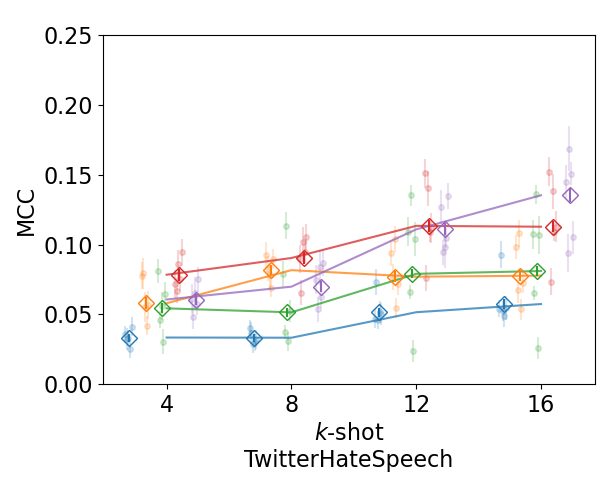

In [10]:
metric = "mcc"

lower_metric = metric.lower()

aggregated_df = normalize_by_group(
    df=all_checkpoint_results,
    by=["k", "learning_algorithm"],
    metric=metric,
)

fig, ax = plt.subplots(1, 1, figsize=figsize)

all_k_shots = [4, 8, 12, 16]

x_ticks = []
x_tick_labels = []

agg_values = defaultdict(list)
custom_lines = []

prev_k_loc = 0
cur_x = 0
for k in all_k_shots:
    matching_k = all_checkpoint_results["k"] == k

    for i, (learning_algorithm, ckpts) in enumerate(checkpoints.items()):
        matching_learning_alg = matching_k & (
            all_checkpoint_results["learning_algorithm"] == learning_algorithm
        )

        color = checkpoint_cmap[learning_algorithm]

        for ckpt in ckpts:
            matching_ckpt = matching_learning_alg & (
                all_checkpoint_results["checkpoint"] == ckpt
            )

            if all_checkpoint_results[matching_ckpt][lower_metric].shape[0] > 1:
                raise KeyboardInterrupt()
            elif all_checkpoint_results[matching_ckpt][lower_metric].shape[0] == 0:
                cur_x += 1
                continue

            value = all_checkpoint_results[matching_ckpt][lower_metric].item()
            value_error = (
                value
                - all_checkpoint_results[matching_ckpt][f"{lower_metric}_lb"].item()
            )

            ax.errorbar(
                cur_x,
                value,
                yerr=value_error,
                fmt="o",
                color=color,
                alpha=0.20,
                zorder=0,
                markersize=markersize_minor,
            )

            cur_x += 1

        agg_row = aggregated_df.xs(key=(k, learning_algorithm))
        agg_value = agg_row[metric].item()
        agg_error = (agg_row[f"{metric}_ub"] - agg_row[metric]).item()

        agg_loc = cur_x - len(ckpts) / 2

        ax.errorbar(
            agg_loc,
            agg_value,
            yerr=agg_error,
            fmt="D",
            color=color,
            alpha=1.0,
            label=learning_algorithm,
            zorder=2,
            markersize=markersize_major,
            fillstyle="none",
        )

        agg_values[learning_algorithm] += [agg_value]

        custom_lines += [
            Line2D([0], [0], marker='D', markerfacecolor=color, color='w', lw=0, markersize=markersize_major),
        ]

        cur_x += 5

    x_ticks += [(prev_k_loc + cur_x) / 2]
    x_tick_labels += [k]

    cur_x += 25
    prev_k_loc = cur_x

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)

all_k_shots_range = np.arange(min(x_ticks), max(x_ticks), step=1, dtype=float)
all_k_shots_x = np.stack(
    [np.ones_like(all_k_shots_range, dtype=float), all_k_shots_range], axis=1
)

for i, (learning_algorithm, values) in enumerate(agg_values.items()):
    color = checkpoint_cmap[learning_algorithm]

    all_k_shots = np.array(x_ticks, dtype=float)

    ax.plot(all_k_shots, values, c=color, alpha=0.75, zorder=1)

ax.set_title(" ", fontsize=11)
ax.set_ylabel("MCC", fontsize=fontsize_major)
ax.set_xlabel("$k$-shot\nTwitterHateSpeech", fontsize=fontsize_major)
ax.tick_params(axis='both', which='major', labelsize=fontsize_major)

ax.set_ylim(0, 0.25)
ax.set_yticks([0.0, 0.05, 0.10, 0.15, 0.20, 0.25])

fig.tight_layout()

plt.show()


In [11]:
twitter_transfer = all_checkpoint_results.copy(deep=True)

In [12]:
all_agg_dfs = []
for metric in ["f1_0", "f1_1", "f1_2", "mcc"]:
    all_agg_dfs += [normalize_by_group(
        df=all_checkpoint_results[all_checkpoint_results["k"] <= 16],
        by=["k", "learning_algorithm"],
        metric=metric,
        remove={"var", "se", "N"}
    )]

all_agg_dfs = pd.concat(
    all_agg_dfs,
    axis=1,
    join="outer"
    ).reset_index()

all_agg_dfs["learning_algorithm"] = pd.Series(pd.Categorical(
    values=all_agg_dfs["learning_algorithm"],
    categories=list(checkpoints.keys()),
    ordered=True
    ))

all_agg_dfs = all_agg_dfs.sort_values(by=["k", "learning_algorithm"]).set_index(keys=["k", "learning_algorithm"])

all_agg_dfs

f1_0   f1_0_lb   f1_0_ub      f1_1   f1_1_lb   
k    learning_algorithm                                                     
4.0  subgraphs           0.161467  0.156286  0.166647  0.195034  0.189376  \
     maml_lh             0.169619  0.163349  0.175889  0.228679  0.223003   
     maml_rh             0.174137  0.168205  0.180068  0.240233  0.235157   
     prototypical        0.194949  0.188009  0.201889  0.235483  0.229851   
     protomaml           0.176295  0.169513  0.183078  0.218085  0.212378   
8.0  subgraphs           0.154550  0.149320  0.159779  0.216118  0.210845   
     maml_lh             0.180238  0.173553  0.186923  0.255241  0.249871   
     maml_rh             0.166926  0.160825  0.173027  0.261376  0.257446   
     prototypical        0.215717  0.209199  0.222234  0.222131  0.216199   
     protomaml           0.193414  0.186623  0.200206  0.214846  0.209194   
12.0 subgraphs           0.189496  0.183825  0.195167  0.216883  0.211334   
     maml_lh             0.189776  0.182958  0.196594  0.254330  0.248667   
     maml_rh             0.228557  0.223514  0.233600  0.252485  0.246845   
     prototypical        0.279755  0.274304  0.285206  0.261173  0.255382   
     protomaml           0.254527  0.247470  0.261584  0.255399  0.249222   
16.0 subgraphs           0.199600  0.193981  0.205219  0.226092  0.220576   
     maml_lh             0.187365  0.180513  0.194216  0.259500  0.253822   
     maml_rh             0.231885  0.226953  0.236816  0.250973  0.245265   
     prototypical        0.288282  0.283846  0.292718  0.257874  0.252274   
     protomaml           0.302084  0.296140  0.308028  0.307706  0.299912   

                          f1_1_ub      f1_2   f1_2_lb   f1_2_ub       mcc   
k    learning_algorithm                                                     
4.0  subgraphs           0.200692  0.374464  0.363411  0.385516  0.033399  \
     maml_lh             0.234355  0.355365  0.346116  0.364613  0.057989   
     maml_rh             0.245308  0.342042  0.332202  0.351882  0.054299   
     prototypical        0.241115  0.393011  0.385063  0.400958  0.078411   
     protomaml           0.223792  0.358484  0.349411  0.367557  0.060653   
8.0  subgraphs           0.221392  0.375023  0.364616  0.385430  0.033262   
     maml_lh             0.260610  0.334011  0.324819  0.343203  0.081684   
     maml_rh             0.265306  0.348046  0.337974  0.358118  0.051453   
     prototypical        0.228064  0.406467  0.399143  0.413791  0.090394   
     protomaml           0.220499  0.352978  0.343917  0.362039  0.069853   
12.0 subgraphs           0.222431  0.368551  0.357577  0.379526  0.051536   
     maml_lh             0.259993  0.306762  0.297569  0.315954  0.076992   
     maml_rh             0.258124  0.318452  0.308396  0.328507  0.079054   
     prototypical        0.266964  0.380343  0.373125  0.387561  0.113441   
     protomaml           0.261575  0.350254  0.341157  0.359351  0.110918   
16.0 subgraphs           0.231609  0.360166  0.349167  0.371165  0.057398   
     maml_lh             0.265179  0.307168  0.297802  0.316534  0.077761   
     maml_rh             0.256681  0.315870  0.305851  0.325888  0.081066   
     prototypical        0.263475  0.374007  0.366435  0.381579  0.112833   
     protomaml           0.315500  0.316347  0.305143  0.327550  0.135359   

                           mcc_lb    mcc_ub  
k    learning_algorithm                      
4.0  subgraphs           0.030528  0.036269  
     maml_lh             0.053887  0.062090  
     maml_rh             0.050740  0.057858  
     prototypical        0.074206  0.082617  
     protomaml           0.056535  0.064771  
8.0  subgraphs           0.030417  0.036106  
     maml_lh             0.078051  0.085316  
     maml_rh             0.048323  0.054584  
     prototypical        0.086236  0.094551  
     protomaml           0.065703  0.074004  
12.0 subgraphs           0.048192  0.054879  
     maml_lh             0.073259  0.0807

In [13]:
gat_all_checkpoint_results = all_checkpoint_results.copy(deep=True)

### Reset GATs

In [14]:
checkpoints = {
    # These were not trained as MAML_RH
    # As these are reset models
    # But the fairest comparsion is to MAML_RH
    "maml_rh": ["vb49pmtr", "8kixi0s8", "vzswebea", "a4xe91oq", "6syunm30"],
    "protomaml": ["9o4wp36l", "ouxd7twt", "aimkj4sa", "euh2mnqo", "p33ybhsn"],
}

reset_checkpoint_results = []
for learning_algorithm, ckpts in checkpoints.items():
    print(learning_algorithm)
    for checkpoint_seed, checkpoint in enumerate(ckpts):

        filters = {
            "dataset": "twitterHateSpeech",
            "top_users_excluded": 0,
            "version": f"reset_{checkpoint}_{checkpoint_seed}",
            "structure_mode": "transductive",
        }

        raw_results, checkpoint_results, checkpoint_results_weighted = get_weighted_results_table(
            filters=filters,
            metrics=metrics,
            split="test",
            alpha=0.10
        )

        checkpoint_results_weighted["checkpoint"] = checkpoint
        checkpoint_results_weighted["learning_algorithm"] = learning_algorithm

        reset_checkpoint_results.append(checkpoint_results_weighted)

#reset_checkpoint_results = reset_checkpoint_results[0]
reset_checkpoint_results = pd.concat(reset_checkpoint_results).reset_index(drop=True)


maml_rh
protomaml


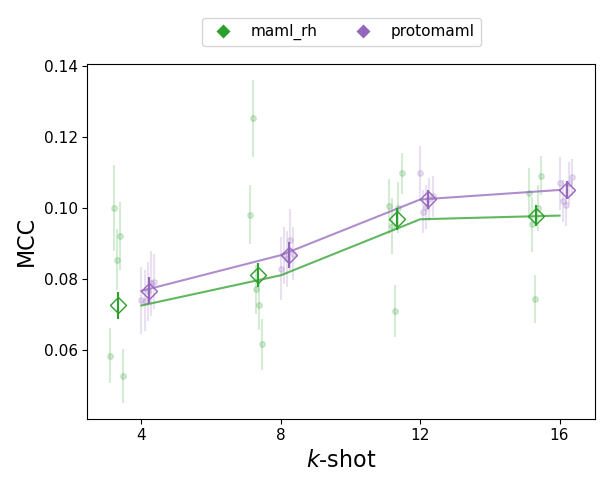

In [15]:
metric = "mcc"

lower_metric = metric.lower()

aggregated_df = normalize_by_group(
    df=reset_checkpoint_results,
    by=["k", "learning_algorithm"],
    metric=metric,
)

fig, ax = plt.subplots(1, 1, figsize=figsize)

all_k_shots = [4, 8, 12, 16]

x_ticks = []
x_tick_labels = []

agg_values = defaultdict(list)
custom_lines = []

prev_k_loc = 0
cur_x = 0
for k in all_k_shots:
    matching_k = reset_checkpoint_results["k"] == k

    for i, (learning_algorithm, ckpts) in enumerate(checkpoints.items()):
        matching_learning_alg = matching_k & (
            reset_checkpoint_results["learning_algorithm"] == learning_algorithm
        )

        color = checkpoint_cmap[learning_algorithm]

        for ckpt in ckpts:
            matching_ckpt = matching_learning_alg & (
                reset_checkpoint_results["checkpoint"] == ckpt
            )

            if reset_checkpoint_results[matching_ckpt][lower_metric].shape[0] > 1:
                raise KeyboardInterrupt()
            elif reset_checkpoint_results[matching_ckpt][lower_metric].shape[0] == 0:
                cur_x += 1
                continue

            value = reset_checkpoint_results[matching_ckpt][lower_metric].item()
            value_error = (
                value
                - reset_checkpoint_results[matching_ckpt][f"{lower_metric}_lb"].item()
            )

            ax.errorbar(
                cur_x,
                value,
                yerr=value_error,
                fmt="o",
                color=color,
                alpha=0.20,
                zorder=0,
                markersize=markersize_minor,
            )

            cur_x += 1

        agg_row = aggregated_df.xs(key=(k, learning_algorithm))
        agg_value = agg_row[metric].item()
        agg_error = (agg_row[f"{metric}_ub"] - agg_row[metric]).item()

        agg_loc = cur_x - len(ckpts) / 2

        ax.errorbar(
            agg_loc,
            agg_value,
            yerr=agg_error,
            fmt="D",
            color=color,
            alpha=1.0,
            label=learning_algorithm,
            zorder=2,
            markersize=markersize_major,
            fillstyle="none",
        )

        agg_values[learning_algorithm] += [agg_value]

        custom_lines += [
            Line2D([0], [0], marker='D', markerfacecolor=color, color='w', lw=0, markersize=markersize_major),
        ]

        cur_x += 5

    x_ticks += [(prev_k_loc + cur_x) / 2]
    x_tick_labels += [k]

    cur_x += 25
    prev_k_loc = cur_x

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)

all_k_shots_range = np.arange(min(x_ticks), max(x_ticks), step=len(all_k_shots) * len(checkpoints), dtype=float)
all_k_shots_x = np.stack(
    [np.ones_like(all_k_shots_range, dtype=float), all_k_shots_range], axis=1
)

for i, (learning_algorithm, values) in enumerate(agg_values.items()):
    color = checkpoint_cmap[learning_algorithm]

    all_k_shots = np.array(x_ticks, dtype=float)

    ax.plot(all_k_shots, values, c=color, alpha=0.75, zorder=1)

#ax.set_title("Twitter Hate Speech", fontsize=11)
ax.set_ylabel("MCC", fontsize=fontsize_major)
ax.set_xlabel("$k$-shot", fontsize=fontsize_major)
ax.tick_params(axis='both', which='major', labelsize=fontsize_minor)

ax.legend(
    custom_lines,
    list(checkpoints.keys()),
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),
    fontsize=fontsize_minor,
    ncol=3,
    )

fig.tight_layout()

plt.show()


In [16]:
all_agg_dfs = []
for metric in ["f1_0", "f1_1", "f1_2", "mcc"]:
    all_agg_dfs += [normalize_by_group(
        df=reset_checkpoint_results,
        by=["k", "learning_algorithm"],
        metric=metric,
        remove={"var", "se", "N"}
    )]

all_agg_dfs = pd.concat(
    all_agg_dfs,
    axis=1,
    join="outer"
    ).reset_index()

all_agg_dfs["learning_algorithm"] = pd.Series(pd.Categorical(
    values=all_agg_dfs["learning_algorithm"],
    categories=list(checkpoints.keys()),
    ordered=True
    ))

all_agg_dfs = all_agg_dfs.sort_values(by=["k", "learning_algorithm"]).set_index(keys=["k", "learning_algorithm"])

all_agg_dfs

f1_0   f1_0_lb   f1_0_ub      f1_1   f1_1_lb   
k  learning_algorithm                                                     
4  maml_rh             0.169880  0.162984  0.176776  0.191776  0.185283  \
   protomaml           0.179879  0.172958  0.186799  0.190556  0.184519   
8  maml_rh             0.223910  0.217765  0.230055  0.169125  0.164034   
   protomaml           0.199930  0.193363  0.206497  0.161661  0.155601   
12 maml_rh             0.231517  0.226388  0.236647  0.134802  0.129155   
   protomaml           0.247093  0.242071  0.252115  0.139858  0.134824   
16 maml_rh             0.236471  0.231926  0.241017  0.129379  0.123917   
   protomaml           0.252446  0.248034  0.256858  0.123267  0.118432   

                        f1_1_ub      f1_2   f1_2_lb   f1_2_ub       mcc   
k  learning_algorithm                                                     
4  maml_rh             0.198270  0.343264  0.334812  0.351717  0.072602  \
   protomaml           0.196592  0.322498  0.313645  0.331351  0.076722   
8  maml_rh             0.174217  0.327677  0.319298  0.336057  0.081119   
   protomaml           0.167720  0.341590  0.333648  0.349533  0.086789   
12 maml_rh             0.140448  0.312473  0.305593  0.319353  0.096913   
   protomaml           0.144892  0.288248  0.279999  0.296497  0.102487   
16 maml_rh             0.134841  0.306483  0.300266  0.312699  0.097956   
   protomaml           0.128102  0.287050  0.278899  0.295200  0.105174   

                         mcc_lb    mcc_ub  
k  learning_algorithm                      
4  maml_rh             0.068693  0.076512  
   protomaml           0.072884  0.080560  
8  maml_rh             0.077677  0.084561  
   protomaml           0.083154  0.090424  
12 maml_rh             0.093772  0.100054  
   protomaml           0.099682  0.105291  
16 maml_rh             0.095022  0.100889  
   protomaml           0.102514  0.107834

#### Comparison

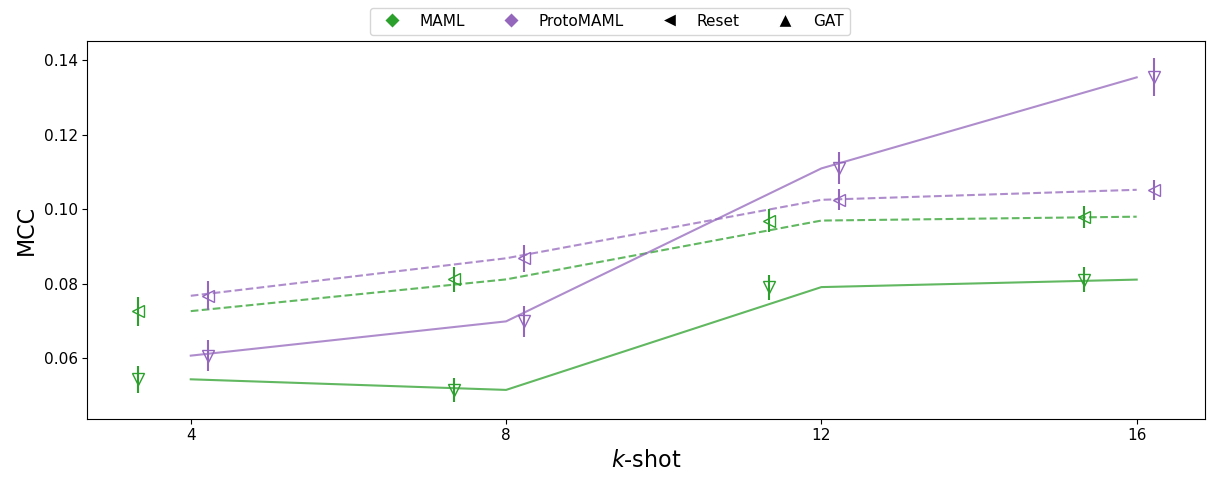

In [17]:
metric = "mcc"

lower_metric = metric.lower()

fig, ax = plt.subplots(1, 1, figsize=(2 * figsize[0], figsize[1]))

all_k_shots = [4, 8, 12, 16]

custom_lines = []

for checkpoint_type, checkpoint_results in [("gat_reset", reset_checkpoint_results), ("gat", gat_all_checkpoint_results)]:
    
    aggregated_df = normalize_by_group(
        df=checkpoint_results,
        by=["k", "learning_algorithm"],
        metric=metric,
    )

    prev_k_loc = 0
    cur_x = 0

    x_ticks = []
    x_tick_labels = []

    agg_values = defaultdict(list)

    for k in all_k_shots:
        matching_k = checkpoint_results["k"] == k

        for i, (learning_algorithm, ckpts) in enumerate(checkpoints.items()):
            matching_learning_alg = matching_k & (
                checkpoint_results["learning_algorithm"] == learning_algorithm
            )

            color = checkpoint_cmap[learning_algorithm]

            for ckpt in ckpts:
                cur_x += 1

            agg_row = aggregated_df.xs(key=(k, learning_algorithm))
            agg_value = agg_row[metric].item()
            agg_error = (agg_row[f"{metric}_ub"] - agg_row[metric]).item()

            agg_loc = cur_x - len(ckpts) / 2

            ax.errorbar(
                agg_loc,
                agg_value,
                yerr=agg_error,
                fmt="<" if checkpoint_type == "gat_reset" else "v",
                color=color,
                alpha=1.0,
                label=learning_algorithm,
                zorder=2,
                markersize=markersize_major,
                fillstyle="none",
            )

            agg_values[learning_algorithm] += [agg_value]

            cur_x += 5

        x_ticks += [(prev_k_loc + cur_x) / 2]
        x_tick_labels += [k]

        cur_x += 25
        prev_k_loc = cur_x

    all_k_shots_range = np.arange(min(x_ticks), max(x_ticks), step=1, dtype=float)
    all_k_shots_x = np.stack(
        [np.ones_like(all_k_shots_range, dtype=float), all_k_shots_range], axis=1
    )

    for i, (learning_algorithm, values) in enumerate(agg_values.items()):
        color = checkpoint_cmap[learning_algorithm]

        all_k_shots_ = np.array(x_ticks, dtype=float)

        ax.plot(
            all_k_shots_,
            values,
            c=color,
            alpha=0.75,
            zorder=1,
            ls="-" if checkpoint_type == "gat" else "--"
            )

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)

for learning_algorithm, ckpts in checkpoints.items():
    
    color = checkpoint_cmap[learning_algorithm]
    
    custom_lines += [
        Line2D([0], [0], marker='D', markerfacecolor=color, color='w', lw=0, markersize=markersize_major),
    ]

custom_lines += [
    Line2D([0], [0], marker='<', markerfacecolor="k", color='w', lw=0, markersize=markersize_major+2),
    Line2D([0], [0], marker='^', markerfacecolor="k", color='w', lw=0, markersize=markersize_major+2),
]

ax.set_title(" ", fontsize=fontsize_major)
ax.set_ylabel("MCC", fontsize=fontsize_major)
ax.set_xlabel("$k$-shot", fontsize=fontsize_major)
ax.tick_params(axis='both', which='major', labelsize=fontsize_minor)

fig.legend(
    custom_lines,
    ["MAML", "ProtoMAML"] + ["Reset", "GAT"],
    loc='upper center',
    #bbox_to_anchor=(0.5, 1.25),
    fontsize=fontsize_minor,
    ncol=4,
    )

fig.tight_layout()

plt.show()


## CoAID

In [18]:
checkpoints = {
    "subgraphs": ["vb49pmtr", "8kixi0s8", "vzswebea", "a4xe91oq", "6syunm30"],
    "maml_lh": ["zqhx6x3b", "11pt2nis", "ruy4hp9o", "nlfyh80j", "06pfaw4f"],
    "maml_rh": ["rpu3r1rm", "35neqj40", "xycl2xbl", "9hdrq4an", "905yf717"],
    "prototypical": ["2crszon2", "wdhcjrmp", "zwwyk83h", "lku2gxb8", "4pj3ewdu"],
    "prototypical": ["yjnx3e9w", "5e0vvr04", "br7qcerq", "6c8tvtwn", "ahp19u65"],
    "protomaml": ["9o4wp36l", "ouxd7twt", "aimkj4sa", "euh2mnqo", "p33ybhsn"],
}

metrics = [
    "supp_improvement",
    "f1_0",
    "f1_1",
    "mcc",
]

all_checkpoint_results = []
for learning_algorithm, ckpts in checkpoints.items():
    print(learning_algorithm)
    for checkpoint in ckpts:

        filters = {
            "dataset": "CoAID",
            "top_users_excluded": 0,
            "version": f"transfer_{checkpoint}",
            "structure_mode": "transductive",
        }

        raw_results, checkpoint_results, checkpoint_results_weighted = get_weighted_results_table(
            filters=filters,
            metrics=metrics,
            split="test",
            alpha=0.10
        )

        checkpoint_results_weighted["checkpoint"] = checkpoint
        checkpoint_results_weighted["learning_algorithm"] = learning_algorithm

        all_checkpoint_results.append(checkpoint_results_weighted)

#all_checkpoint_results = all_checkpoint_results[0]
all_checkpoint_results = pd.concat(all_checkpoint_results).reset_index(drop=True)


subgraphs


/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]
/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]
/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]
/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]
/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]
/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]


maml_lh


/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]
/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]
/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]
/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]


maml_rh


/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]
/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]


prototypical


/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]
/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]
/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]


protomaml


/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]
/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]
/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]
/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]


In [19]:
# Filter out some early attempts with too high learning rate
# These are noisy data points
all_checkpoint_results = all_checkpoint_results[~((all_checkpoint_results.class_weights == (1.0, 20.0)) | (all_checkpoint_results.class_weights == (1.0, 3.0)))]

all_checkpoint_results[(all_checkpoint_results["n_updates"] == 25)] = (
    all_checkpoint_results[(all_checkpoint_results["n_updates"] == 25)]
    .sort_values(by=["learning_algorithm", "checkpoint", "k", "inner_lr", "inner_head_lr"])
    .drop_duplicates(subset=["learning_algorithm", "checkpoint", "k"])
)

all_checkpoint_results.dropna(inplace=True)

all_checkpoint_results

,k,n_updates,inner_lr,inner_head_lr,class_weights,budget,reset,user_init,supp_improvement,supp_improvement_var,...,f1_1_ub,f1_1_N,mcc,mcc_var,mcc_se,mcc_lb,mcc_ub,mcc_N,checkpoint,learning_algorithm
0,12,5,0.010,0.05,"(1.0, 1.0)",2048,False,False,2.722816e-01,1.576908e-05,...,0.095243,256.0,0.026916,0.000003,0.001603,0.024270,0.029562,256.0,vb49pmtr,subgraphs
1,12,25,0.005,0.05,"(1.0, 1.0)",2048,False,False,3.091608e-01,1.669698e-05,...,0.080068,256.0,0.030899,0.000004,0.001973,0.027642,0.034157,256.0,vb49pmtr,subgraphs
2,12,1,0.000,0.00,"(1.0, 1.0)",2048,False,False,-8.381903e-09,8.758653e-18,...,0.093372,256.0,0.012508,0.000001,0.001200,0.010527,0.014489,256.0,vb49pmtr,subgraphs
3,4,25,0.005,0.05,"(1.0, 1.0)",2048,False,False,4.817080e-01,1.093859e-04,...,0.096705,256.0,0.036471,0.000004,0.001914,0.033312,0.039631,256.0,vb49pmtr,subgraphs
4,4,5,0.010,0.05,"(1.0, 1.0)",2048,False,False,3.379230e-01,3.718113e-05,...,0.100815,256.0,0.022376,0.000002,0.001405,0.020056,0.024696,256.0,vb49pmtr,subgraphs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,4,25,0.010,0.50,"(1.0, 1.0)",2048,False,False,4.799494e-01,3.324256e-04,...,0.250084,256.0,0.218704,0.000039,0.006216,0.208443,0.228965,256.0,p33ybhsn,protomaml
233,8,10,0.010,0.05,"(1.0, 1.0)",2048,False,False,2.059408e-01,7.463513e-05,...,0.248706,256.0,0.236150,0.000010,0.003223,0.230829,0.241472,256.0,p33ybhsn,protomaml
234,8,25,0.010,0.50,"(1.0, 1.0)",2048,False,False,3.329557e-01,1.427716e-04,...,0.260749,256.0,0.246153,0.000013,0.003667,0.240099,0.252207,256.0,p33ybhsn,protomaml
238,16,10,0.010,0.05,"(1.0, 1.0)",2048,False,False,1.353890e-01,2.365746e-05,...,0.214074,255.0,0.215129,0.000005,0.002304,0.211325,0.218933,255.0,p33ybhsn,protomaml


### Low Adaptation

In [20]:
zero_shot_transfer_baseline = all_checkpoint_results[(all_checkpoint_results["learning_algorithm"] == "subgraphs") & (all_checkpoint_results["inner_lr"] == 0.0)]
zero_shot_transfer_baseline = zero_shot_transfer_baseline[zero_shot_transfer_baseline["k"] == 4]

low_adaptation_checkpoints = pd.concat([zero_shot_transfer_baseline, all_checkpoint_results]).drop_duplicates(subset=["k", "n_updates", "inner_lr", "inner_head_lr", "checkpoint"], keep=False)
low_adaptation_checkpoints = low_adaptation_checkpoints.sort_values(by=["k", "learning_algorithm", "n_updates", "inner_lr",])
low_adaptation_checkpoints = low_adaptation_checkpoints.drop_duplicates(subset=["k", "learning_algorithm", "checkpoint",], keep="first")

zero_shot_transfer_baseline["k"] = 0
low_adaptation_checkpoints = pd.concat([zero_shot_transfer_baseline, low_adaptation_checkpoints])

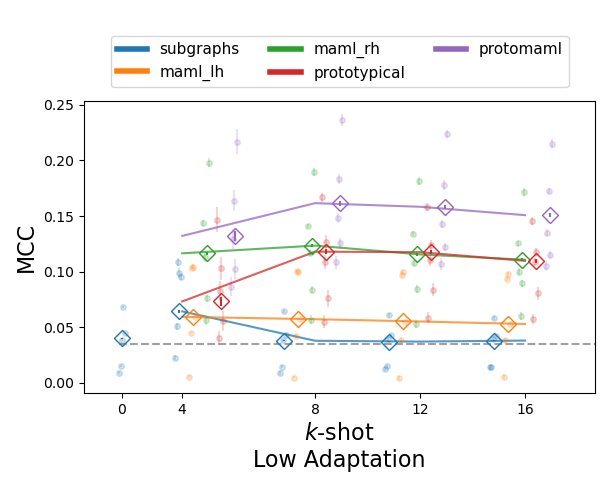

In [21]:
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

metric = "mcc"

lower_metric = metric.lower()

aggregated_df = normalize_by_group(
    df=low_adaptation_checkpoints,
    by=["k", "learning_algorithm"],
    metric=metric,
)

learning_algorithms_with_values = set(aggregated_df.index.get_level_values(level=1).unique().to_list())

fig, ax = plt.subplots(1, 1, figsize=figsize)

all_k_shots = [4, 8, 12, 16]

x_ticks = []
x_tick_labels = []

agg_locs = defaultdict(list)
agg_values = defaultdict(list)

prev_k_loc = 0
cur_x = 0

zero_shot_vals = zero_shot_transfer_baseline[metric].to_numpy()
zero_shot_error = zero_shot_vals - zero_shot_transfer_baseline[f"{lower_metric}_lb"].to_numpy()

ax.errorbar(
    x=np.arange(cur_x, cur_x + zero_shot_vals.shape[0]),
    y=zero_shot_vals,
    yerr=zero_shot_error,
    fmt='o',
    color=checkpoint_cmap["zero_shot_transfer"],
    alpha=0.20,
    zorder=1,
    markersize=markersize_minor,
    )

ax.errorbar(
    np.arange(cur_x, cur_x + zero_shot_vals.shape[0]).mean(),
    aggregated_df.xs((0.0, "subgraphs"))[f"{lower_metric}"],
    yerr=aggregated_df.xs((0.0, "subgraphs"))[f"{metric}_ub"]-aggregated_df.xs((0.0, "subgraphs"))[f"{lower_metric}"],
    fmt='D',
    color=checkpoint_cmap["zero_shot_transfer"],
    alpha=1.0,
    label=learning_algorithm,
    zorder=2,
    markersize=markersize_major,
    fillstyle="none",
    )

ax.hlines(
    y=zero_shot_vals.mean(), 
    xmin=0,
    xmax=1000,
    colors=["gray"],
    zorder=1,
    linestyles="--",
    alpha=0.75,
    )

x_ticks += [np.arange(cur_x, cur_x + zero_shot_vals.shape[0]).mean()]
x_tick_labels += ["0"]

cur_x = zero_shot_vals.shape[0] + 35

for k in all_k_shots:
    matching_k = low_adaptation_checkpoints["k"] == k
    
    for i, (learning_algorithm, ckpts) in enumerate(checkpoints.items()):
        
        if learning_algorithm not in learning_algorithms_with_values:
            continue
        
        matching_learning_alg = matching_k & (low_adaptation_checkpoints["learning_algorithm"] == learning_algorithm)
        
        for ckpt in ckpts:
            matching_ckpt = matching_learning_alg & (low_adaptation_checkpoints["checkpoint"] == ckpt)
            
            if low_adaptation_checkpoints[matching_ckpt][lower_metric].shape[0] > 1:
                raise KeyboardInterrupt()
            elif low_adaptation_checkpoints[matching_ckpt][lower_metric].shape[0] == 0:
                cur_x += 1
                continue
                        
            value = low_adaptation_checkpoints[matching_ckpt][lower_metric].item()
            value_error = value - low_adaptation_checkpoints[matching_ckpt][f"{lower_metric}_lb"].item()
            
            ax.errorbar(cur_x, value, yerr=value_error, fmt='o', color=cmap(i), alpha=0.20, zorder=1, markersize=markersize_minor)
            
            cur_x += 1

        agg_loc = cur_x - len(ckpts) / 2
        agg_value = aggregated_df.xs((k, learning_algorithm))[metric]
        agg_error = aggregated_df.xs((k, learning_algorithm))[f"{lower_metric}_ub"] - aggregated_df.xs((k, learning_algorithm))[metric]

        agg_locs[learning_algorithm] += [agg_loc]
        agg_values[learning_algorithm] += [agg_value]
        
        ax.errorbar(agg_loc, agg_value, yerr=agg_error, fmt='D', color=cmap(i), alpha=1.0, label=learning_algorithm, zorder=2, markersize=markersize_major, fillstyle="none",)
        
        cur_x += 5

    x_ticks += [(prev_k_loc + cur_x) / 2]
    x_tick_labels += [k]
    
    cur_x += 25
    prev_k_loc = cur_x

ax.set_xlim(-25, cur_x)

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)

custom_lines = [
    Line2D([0], [0], color=cmap(0), lw=4),
    Line2D([0], [0], color=cmap(1), lw=4),
    Line2D([0], [0], color=cmap(2), lw=4),
    Line2D([0], [0], color=cmap(3), lw=4),
    Line2D([0], [0], color=cmap(4), lw=4),
    ]

#ax.legend(custom_lines, list(checkpoints.keys()))

all_k_shots_range = np.arange(min(x_ticks[1:]), max(x_ticks[1:]), step=1, dtype=float)
all_k_shots_x = np.stack([np.ones_like(all_k_shots_range, dtype=float), all_k_shots_range], axis=1)

for i, (learning_algorithm, values) in enumerate(agg_values.items()):

    color = checkpoint_cmap[learning_algorithm]

    all_k_shots = np.array(x_ticks[1:], dtype=float)
    
    ax.plot(all_k_shots, values, c=color, alpha=0.75, zorder=1)

#ax.set_title("HealthStory\n(low adaptation)", fontsize=11)
ax.set_ylabel("MCC", fontsize=fontsize_major)
ax.set_xlabel("$k$-shot\nLow Adaptation", fontsize=fontsize_major)

ax.legend(
    custom_lines,
    list(checkpoints.keys()),
    loc='upper center',
    bbox_to_anchor=(0.5, 1.25),
    fontsize=fontsize_minor,
    ncol=3,
    )

fig.tight_layout()

plt.show()


In [22]:
all_agg_dfs = []
for metric in ["f1_0", "f1_1", "mcc"]:
    all_agg_dfs += [normalize_by_group(
        df=low_adaptation_checkpoints,
        by=["k", "learning_algorithm"],
        metric=metric,
        remove={"var", "se", "N"}
    )]

all_agg_dfs = pd.concat(
    all_agg_dfs,
    axis=1,
    join="outer"
    ).reset_index()

all_agg_dfs["learning_algorithm"] = pd.Series(pd.Categorical(
    values=all_agg_dfs["learning_algorithm"],
    categories=list(checkpoints.keys()),
    ordered=True
    ))

all_agg_dfs = all_agg_dfs.sort_values(by=["k", "learning_algorithm"]).set_index(keys=["k", "learning_algorithm"])

all_agg_dfs

f1_0   f1_0_lb   f1_0_ub      f1_1   f1_1_lb   
k  learning_algorithm                                                     
0  subgraphs           0.244520  0.244451  0.244588  0.112100  0.111983  \
4  subgraphs           0.716381  0.710016  0.722746  0.130552  0.128956   
   maml_lh             0.422542  0.422379  0.422704  0.116233  0.116071   
   maml_rh             0.824138  0.819794  0.828482  0.156113  0.154758   
   prototypical        0.700656  0.692811  0.708500  0.140429  0.138786   
   protomaml           0.786680  0.779111  0.794250  0.176701  0.174582   
8  subgraphs           0.221861  0.221770  0.221952  0.104437  0.104282   
   maml_lh             0.569301  0.569137  0.569465  0.109572  0.109358   
   maml_rh             0.824278  0.820778  0.827777  0.156659  0.155618   
   prototypical        0.754050  0.749258  0.758841  0.147090  0.145776   
   protomaml           0.830022  0.825957  0.834086  0.179909  0.178418   
12 subgraphs           0.238736  0.238620  0.238852  0.097352  0.097164   
   maml_lh             0.573974  0.573802  0.574145  0.102755  0.102511   
   maml_rh             0.835546  0.832820  0.838272  0.146638  0.145732   
   prototypical        0.756041  0.751659  0.760422  0.139455  0.138383   
   protomaml           0.833127  0.829549  0.836705  0.167474  0.166237   
16 subgraphs           0.229561  0.229430  0.229693  0.089613  0.089412   
   maml_lh             0.587086  0.586914  0.587257  0.095621  0.095352   
   maml_rh             0.831550  0.829108  0.833991  0.135225  0.134344   
   prototypical        0.742864  0.738269  0.747459  0.126826  0.125884   
   protomaml           0.832269  0.829077  0.835461  0.152961  0.151827   

                        f1_1_ub       mcc    mcc_lb    mcc_ub  
k  learning_algorithm                                          
0  subgraphs           0.112218  0.039780  0.039361  0.040198  
4  subgraphs           0.132149  0.064183  0.062811  0.065555  
   maml_lh             0.116394  0.059268  0.059187  0.059349  
   maml_rh             0.157468  0.116431  0.114941  0.117920  
   prototypical        0.142072  0.073134  0.069188  0.077080  
   protomaml           0.178820  0.132096  0.127928  0.136263  
8  subgraphs           0.104591  0.037738  0.037150  0.038325  
   maml_lh             0.109785  0.057140  0.057035  0.057245  
   maml_rh             0.157701  0.123400  0.122103  0.124697  
   prototypical        0.148403  0.117934  0.115384  0.120483  
   protomaml           0.181400  0.161568  0.159374  0.163763  
12 subgraphs           0.097541  0.037005  0.036283  0.037727  
   maml_lh             0.102999  0.055088  0.054965  0.055211  
   maml_rh             0.147543  0.115445  0.114162  0.116728  
   prototypical        0.140527  0.117467  0.115398  0.119537  
   protomaml           0.168711  0.158324  0.156560  0.160088  
16 subgraphs           0.089813  0.037922  0.037115  0.038728  
   maml_lh             0.095891  0.052816  0.052686  0.052947  
   maml_rh             0.136106  0.110645  0.109298  0.111992  
   prototypical        0.127767  0.109675  0.107869  0.111482  
   protomaml           0.154096  0.150778  0.149283  0.152272

### High Adaptation

In [23]:
zero_shot_transfer_baseline = all_checkpoint_results[(all_checkpoint_results["learning_algorithm"] == "subgraphs") & (all_checkpoint_results["inner_lr"] == 0.0)]
zero_shot_transfer_baseline = zero_shot_transfer_baseline[zero_shot_transfer_baseline["k"] == 4]

high_adaptation_checkpoints = pd.concat([zero_shot_transfer_baseline, all_checkpoint_results]).drop_duplicates(subset=["k", "n_updates", "inner_lr", "inner_head_lr", "checkpoint"], keep=False)
high_adaptation_checkpoints = high_adaptation_checkpoints.sort_values(by=["k", "learning_algorithm", "n_updates", "inner_lr",])
high_adaptation_checkpoints = high_adaptation_checkpoints.drop_duplicates(subset=["k", "learning_algorithm", "checkpoint",], keep="last")

zero_shot_transfer_baseline["k"] = 0
high_adaptation_checkpoints = pd.concat([zero_shot_transfer_baseline, high_adaptation_checkpoints])

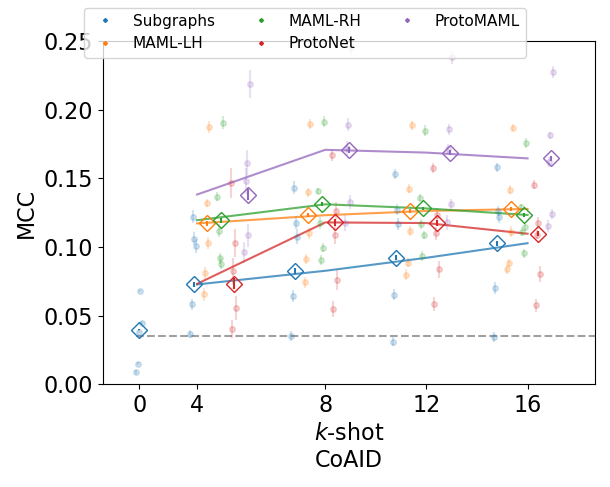

In [24]:
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

metric = "mcc"

lower_metric = metric.lower()

aggregated_df = normalize_by_group(
    df=high_adaptation_checkpoints,
    by=["k", "learning_algorithm"],
    metric=metric,
)

learning_algorithms_with_values = set(aggregated_df.index.get_level_values(level=1).unique().to_list())

fig, ax = plt.subplots(1, 1, figsize=figsize)

all_k_shots = [4, 8, 12, 16]

x_ticks = []
x_tick_labels = []

agg_locs = defaultdict(list)
agg_values = defaultdict(list)

prev_k_loc = 0
cur_x = 0

zero_shot_vals = zero_shot_transfer_baseline[metric].to_numpy()
zero_shot_error = zero_shot_vals - zero_shot_transfer_baseline[f"{lower_metric}_lb"].to_numpy()

ax.errorbar(
    x=np.arange(cur_x, cur_x + zero_shot_vals.shape[0]),
    y=zero_shot_vals,
    yerr=zero_shot_error,
    fmt='o',
    color=checkpoint_cmap["zero_shot_transfer"],
    alpha=0.20,
    zorder=1,
    markersize=markersize_minor,
    )

ax.errorbar(
    np.arange(cur_x, cur_x + zero_shot_vals.shape[0]).mean(),
    aggregated_df.xs((0.0, "subgraphs"))[f"{lower_metric}"],
    yerr=aggregated_df.xs((0.0, "subgraphs"))[f"{lower_metric}_ub"]-aggregated_df.xs((0.0, "subgraphs"))[f"{lower_metric}"],
    fmt='D',
    color=checkpoint_cmap["zero_shot_transfer"],
    alpha=1.0,
    label=learning_algorithm,
    zorder=2,
    markersize=markersize_major,
    fillstyle="none",
    )

ax.hlines(
    y=zero_shot_vals.mean(), 
    xmin=0,
    xmax=1000,
    colors=["gray"],
    zorder=1,
    linestyles="--",
    alpha=0.75,
    )

x_ticks += [np.arange(cur_x, cur_x + zero_shot_vals.shape[0]).mean()]
x_tick_labels += ["0"]

cur_x = zero_shot_vals.shape[0] + 35

for k in all_k_shots:
    matching_k = high_adaptation_checkpoints["k"] == k
    
    for i, (learning_algorithm, ckpts) in enumerate(checkpoints.items()):
        
        if learning_algorithm not in learning_algorithms_with_values:
            continue
        
        matching_learning_alg = matching_k & (high_adaptation_checkpoints["learning_algorithm"] == learning_algorithm)
        
        for ckpt in ckpts:
            matching_ckpt = matching_learning_alg & (high_adaptation_checkpoints["checkpoint"] == ckpt)
            
            if high_adaptation_checkpoints[matching_ckpt][lower_metric].shape[0] > 1:
                raise KeyboardInterrupt()
            elif high_adaptation_checkpoints[matching_ckpt][lower_metric].shape[0] == 0:
                cur_x += 1
                continue
                        
            value = high_adaptation_checkpoints[matching_ckpt][lower_metric].item()
            value_error = value - high_adaptation_checkpoints[matching_ckpt][f"{lower_metric}_lb"].item()
            
            ax.errorbar(cur_x, value, yerr=value_error, fmt='o', color=cmap(i), alpha=0.20, zorder=1, markersize=markersize_minor)
            
            cur_x += 1

        agg_loc = cur_x - len(ckpts) / 2
        agg_value = aggregated_df.xs((k, learning_algorithm))[metric]
        agg_error = aggregated_df.xs((k, learning_algorithm))[f"{metric}_ub"] - aggregated_df.xs((k, learning_algorithm))[metric]

        agg_locs[learning_algorithm] += [agg_loc]
        agg_values[learning_algorithm] += [agg_value]
        
        ax.errorbar(agg_loc, agg_value, yerr=agg_error, fmt='D', color=cmap(i), alpha=1.0, label=learning_algorithm, zorder=2, markersize=markersize_major, fillstyle="none",)
        
        cur_x += 5

    x_ticks += [(prev_k_loc + cur_x) / 2]
    x_tick_labels += [k]
    
    cur_x += 25
    prev_k_loc = cur_x

ax.set_xlim(-25, cur_x)

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)

custom_lines = [
    Line2D([0], [0], color=cmap(0), lw=0, marker="D", markersize=2),
    Line2D([0], [0], color=cmap(1), lw=0, marker="D", markersize=2),
    Line2D([0], [0], color=cmap(2), lw=0, marker="D", markersize=2),
    Line2D([0], [0], color=cmap(3), lw=0, marker="D", markersize=2),
    Line2D([0], [0], color=cmap(4), lw=0, marker="D", markersize=2),
    ]

#ax.legend(custom_lines, list(checkpoints.keys()))

all_k_shots_range = np.arange(min(x_ticks[1:]), max(x_ticks[1:]), step=1, dtype=float)
all_k_shots_x = np.stack([np.ones_like(all_k_shots_range, dtype=float), all_k_shots_range], axis=1)

for i, (learning_algorithm, values) in enumerate(agg_values.items()):

    color = checkpoint_cmap[learning_algorithm]

    all_k_shots = np.array(x_ticks[1:], dtype=float)
    
    ax.plot(all_k_shots, values, c=color, alpha=0.75, zorder=1)

ax.set_title(" ", fontsize=fontsize_major)
ax.set_ylabel("MCC", fontsize=fontsize_major)
ax.set_xlabel("$k$-shot\nCoAID", fontsize=fontsize_major)
ax.tick_params(axis='both', which='major', labelsize=fontsize_major)

ax.set_ylim(0, 0.25)
ax.set_yticks([0.0, 0.05, 0.10, 0.15, 0.20, 0.25])

fig.legend(
    custom_lines,
    ["Subgraphs", "MAML-LH", "MAML-RH", "ProtoNet", "ProtoMAML"],
    loc='upper center',
    #bbox_to_anchor=(0.5, 1.25),
    fontsize=fontsize_minor,
    ncol=3,
    )

fig.tight_layout()

plt.show()

In [25]:
coaid_transfer = high_adaptation_checkpoints.copy(deep=True)

In [26]:
all_agg_dfs = []
for metric in ["f1_0", "f1_1", "mcc"]:
    all_agg_dfs += [normalize_by_group(
        df=high_adaptation_checkpoints,
        by=["k", "learning_algorithm"],
        metric=metric,
        remove={"var", "se", "N"}
    )]

all_agg_dfs = pd.concat(
    all_agg_dfs,
    axis=1,
    join="outer"
    ).reset_index()

all_agg_dfs["learning_algorithm"] = pd.Series(pd.Categorical(
    values=all_agg_dfs["learning_algorithm"],
    categories=list(checkpoints.keys()),
    ordered=True
    ))

all_agg_dfs = all_agg_dfs.sort_values(by=["k", "learning_algorithm"]).set_index(keys=["k", "learning_algorithm"])

all_agg_dfs

f1_0   f1_0_lb   f1_0_ub      f1_1   f1_1_lb   
k  learning_algorithm                                                     
0  subgraphs           0.244520  0.244451  0.244588  0.112100  0.111983  \
4  subgraphs           0.726958  0.719855  0.734060  0.130980  0.128857   
   maml_lh             0.749384  0.743450  0.755317  0.153787  0.152382   
   maml_rh             0.779736  0.774395  0.785076  0.156231  0.154738   
   prototypical        0.700656  0.692811  0.708500  0.140429  0.138786   
   protomaml           0.773377  0.765540  0.781213  0.176172  0.173989   
8  subgraphs           0.765072  0.759655  0.770489  0.128991  0.126788   
   maml_lh             0.767889  0.763330  0.772449  0.152456  0.151185   
   maml_rh             0.802131  0.798336  0.805927  0.158149  0.156973   
   prototypical        0.754050  0.749258  0.758841  0.147090  0.145776   
   protomaml           0.824488  0.820180  0.828797  0.184128  0.182434   
12 subgraphs           0.778263  0.773978  0.782547  0.131563  0.129699   
   maml_lh             0.789346  0.785642  0.793050  0.147008  0.145863   
   maml_rh             0.818110  0.814909  0.821311  0.150534  0.149458   
   prototypical        0.756041  0.751659  0.760422  0.139455  0.138383   
   protomaml           0.829389  0.825506  0.833271  0.173153  0.171752   
16 subgraphs           0.792154  0.788689  0.795619  0.131442  0.129844   
   maml_lh             0.806013  0.803313  0.808713  0.138540  0.137528   
   maml_rh             0.816540  0.813858  0.819223  0.140531  0.139631   
   prototypical        0.742864  0.738269  0.747459  0.126826  0.125884   
   protomaml           0.832081  0.828765  0.835398  0.159927  0.158683   

                        f1_1_ub       mcc    mcc_lb    mcc_ub  
k  learning_algorithm                                          
0  subgraphs           0.112218  0.039780  0.039361  0.040198  
4  subgraphs           0.133102  0.072708  0.070826  0.074590  
   maml_lh             0.155192  0.117197  0.115417  0.118978  
   maml_rh             0.157724  0.119550  0.117743  0.121357  
   prototypical        0.142072  0.073134  0.069188  0.077080  
   protomaml           0.178355  0.138265  0.134288  0.142241  
8  subgraphs           0.131193  0.082656  0.080664  0.084648  
   maml_lh             0.153727  0.123190  0.121550  0.124830  
   maml_rh             0.159325  0.131152  0.129686  0.132619  
   prototypical        0.148403  0.117934  0.115384  0.120483  
   protomaml           0.185823  0.170888  0.168477  0.173298  
12 subgraphs           0.133428  0.092124  0.090373  0.093875  
   maml_lh             0.148152  0.126330  0.124790  0.127871  
   maml_rh             0.151611  0.128125  0.126728  0.129523  
   prototypical        0.140527  0.117467  0.115398  0.119537  
   protomaml           0.174554  0.168855  0.166863  0.170848  
16 subgraphs           0.133040  0.102780  0.101089  0.104471  
   maml_lh             0.139552  0.127734  0.126330  0.129138  
   maml_rh             0.141432  0.123362  0.122074  0.124651  
   prototypical        0.127767  0.109675  0.107869  0.111482  
   protomaml           0.161170  0.164634  0.163059  0.166208

### Reset GATs

In [27]:
checkpoints = {
    # These were not trained as MAML_RH
    # As these are reset models
    # But the fairest comparsion is to MAML_RH
    "maml_rh": ["vb49pmtr", "8kixi0s8", "vzswebea", "a4xe91oq", "6syunm30"],
    "protomaml": ["9o4wp36l", "ouxd7twt", "aimkj4sa", "euh2mnqo", "p33ybhsn"],
}

reset_checkpoint_results = []
for learning_algorithm, ckpts in checkpoints.items():
    print(learning_algorithm)
    for checkpoint_seed, checkpoint in enumerate(ckpts):

        filters = {
            "dataset": "CoAID",
            "top_users_excluded": 0,
            "version": f"reset_{checkpoint}_{checkpoint_seed}",
            "structure_mode": "transductive",
        }

        raw_results, checkpoint_results, checkpoint_results_weighted = get_weighted_results_table(
            filters=filters,
            metrics=metrics,
            split="test",
            alpha=0.10
        )

        checkpoint_results_weighted["checkpoint"] = checkpoint
        checkpoint_results_weighted["learning_algorithm"] = learning_algorithm

        reset_checkpoint_results.append(checkpoint_results_weighted)

#reset_checkpoint_results = reset_checkpoint_results[0]
reset_checkpoint_results = pd.concat(reset_checkpoint_results).reset_index(drop=True)

maml_rh


/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]


protomaml


/tmp/ipykernel_27517/2443725077.py:64: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / v_arr[:, 1]


In [28]:
reset_checkpoint_results = reset_checkpoint_results[reset_checkpoint_results["class_weights"] == (1.0, 1.0)]

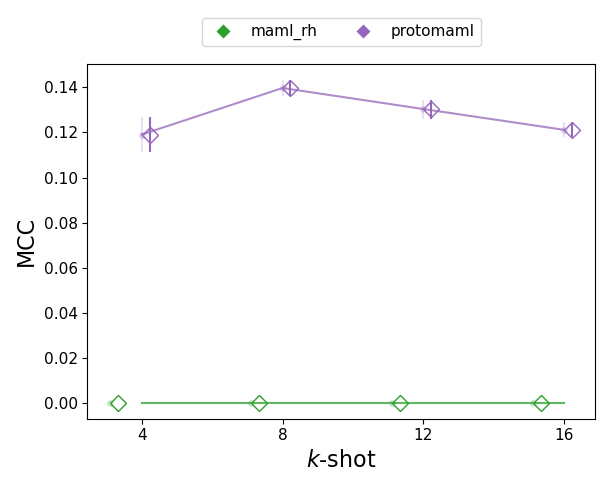

In [29]:
metric = "mcc"

lower_metric = metric.lower()

aggregated_df = normalize_by_group(
    df=reset_checkpoint_results,
    by=["k", "learning_algorithm"],
    metric=metric,
)

fig, ax = plt.subplots(1, 1, figsize=figsize)

all_k_shots = [4, 8, 12, 16]

x_ticks = []
x_tick_labels = []

agg_values = defaultdict(list)
custom_lines = []

prev_k_loc = 0
cur_x = 0
for k in all_k_shots:
    matching_k = reset_checkpoint_results["k"] == k

    for i, (learning_algorithm, ckpts) in enumerate(checkpoints.items()):
        matching_learning_alg = matching_k & (
            reset_checkpoint_results["learning_algorithm"] == learning_algorithm
        )

        color = checkpoint_cmap[learning_algorithm]

        for ckpt in ckpts:
            matching_ckpt = matching_learning_alg & (
                reset_checkpoint_results["checkpoint"] == ckpt
            )

            if reset_checkpoint_results[matching_ckpt][lower_metric].shape[0] > 1:
                raise KeyboardInterrupt()
            elif reset_checkpoint_results[matching_ckpt][lower_metric].shape[0] == 0:
                cur_x += 1
                continue

            value = reset_checkpoint_results[matching_ckpt][lower_metric].item()
            value_error = (
                value
                - reset_checkpoint_results[matching_ckpt][f"{lower_metric}_lb"].item()
            )

            ax.errorbar(
                cur_x,
                value,
                yerr=value_error,
                fmt="o",
                color=color,
                alpha=0.20,
                zorder=0,
                markersize=markersize_minor,
            )

            cur_x += 1

        agg_row = aggregated_df.xs(key=(k, learning_algorithm))
        agg_value = agg_row[metric].item()
        agg_error = (agg_row[f"{metric}_ub"] - agg_row[metric]).item()

        agg_loc = cur_x - len(ckpts) / 2

        ax.errorbar(
            agg_loc,
            agg_value,
            yerr=agg_error,
            fmt="D",
            color=color,
            alpha=1.0,
            label=learning_algorithm,
            zorder=2,
            markersize=markersize_major,
            fillstyle="none",
        )

        agg_values[learning_algorithm] += [agg_value]

        custom_lines += [
            Line2D([0], [0], marker='D', markerfacecolor=color, color='w', lw=0, markersize=markersize_major),
        ]

        cur_x += 5

    x_ticks += [(prev_k_loc + cur_x) / 2]
    x_tick_labels += [k]

    cur_x += 25
    prev_k_loc = cur_x

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)

all_k_shots_range = np.arange(min(x_ticks), max(x_ticks), step=len(all_k_shots) * len(checkpoints), dtype=float)
all_k_shots_x = np.stack(
    [np.ones_like(all_k_shots_range, dtype=float), all_k_shots_range], axis=1
)

for i, (learning_algorithm, values) in enumerate(agg_values.items()):
    color = checkpoint_cmap[learning_algorithm]

    all_k_shots = np.array(x_ticks, dtype=float)

    ax.plot(all_k_shots, values, c=color, alpha=0.75, zorder=1)

#ax.set_title("Twitter Hate Speech", fontsize=11)
ax.set_ylabel("MCC", fontsize=fontsize_major)
ax.set_xlabel("$k$-shot", fontsize=fontsize_major)
ax.tick_params(axis='both', which='major', labelsize=fontsize_minor)

ax.legend(
    custom_lines,
    list(checkpoints.keys()),
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),
    fontsize=fontsize_minor,
    ncol=3,
    )

fig.tight_layout()

plt.show()


In [30]:
all_agg_dfs = []
for metric in ["f1_0", "f1_1", "mcc"]:
    all_agg_dfs += [normalize_by_group(
        df=reset_checkpoint_results,
        by=["k", "learning_algorithm"],
        metric=metric,
        remove={"var", "se", "N"}
    )]
    
all_agg_dfs = pd.concat(
    all_agg_dfs,
    axis=1,
    join="outer"
    ).reset_index()

all_agg_dfs["learning_algorithm"] = pd.Series(pd.Categorical(
    values=all_agg_dfs["learning_algorithm"],
    categories=list(checkpoints.keys()),
    ordered=True
    ))

all_agg_dfs = all_agg_dfs.sort_values(by=["k", "learning_algorithm"]).set_index(keys=["k", "learning_algorithm"])

all_agg_dfs


f1_0   f1_0_lb   f1_0_ub      f1_1   f1_1_lb   
k    learning_algorithm                                                     
4.0  maml_rh             0.971045  0.970991  0.971100  0.000000  0.000000  \
     protomaml           0.786908  0.767362  0.806453  0.171564  0.167261   
8.0  maml_rh             0.973150  0.973076  0.973224  0.000000  0.000000   
     protomaml           0.848323  0.839395  0.857250  0.176918  0.173818   
12.0 maml_rh             0.975203  0.975119  0.975288  0.000000  0.000000   
     protomaml           0.846987  0.836808  0.857166  0.165239  0.162142   
16.0 maml_rh             0.977393  0.977297  0.977490  0.000000  0.000000   
     protomaml           0.854194  0.847869  0.860520  0.150380  0.147491   

                          f1_1_ub       mcc    mcc_lb    mcc_ub  
k    learning_algorithm                                          
4.0  maml_rh             0.000000  0.000000  0.000000  0.000000  
     protomaml           0.175867  0.119087  0.111420  0.126754  
8.0  maml_rh             0.000000  0.000000  0.000000  0.000000  
     protomaml           0.180018  0.139761  0.136093  0.143430  
12.0 maml_rh             0.000000  0.000000  0.000000  0.000000  
     protomaml           0.168337  0.130425  0.126196  0.134653  
16.0 maml_rh             0.000000  0.000000  0.000000  0.000000  
     protomaml           0.153269  0.121176  0.117888  0.124464

#### Comparison

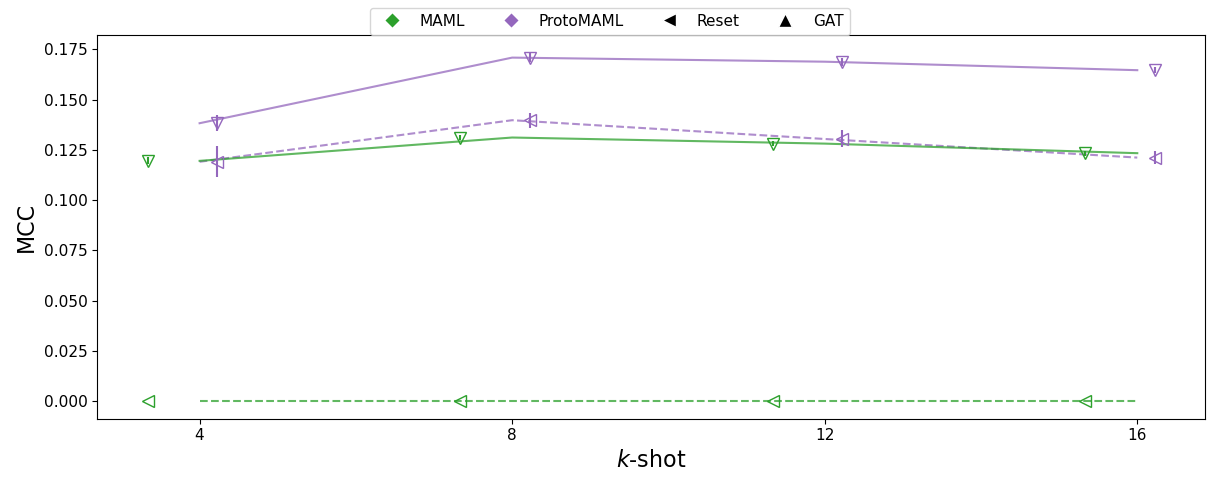

In [31]:
metric = "mcc"

lower_metric = metric.lower()

fig, ax = plt.subplots(1, 1, figsize=(2 * figsize[0], figsize[1]))

all_k_shots = [4, 8, 12, 16]

custom_lines = []

for checkpoint_type, checkpoint_results in [("gat_reset", reset_checkpoint_results), ("gat", high_adaptation_checkpoints)]:
    
    aggregated_df = normalize_by_group(
        df=checkpoint_results,
        by=["k", "learning_algorithm"],
        metric=metric,
    )

    prev_k_loc = 0
    cur_x = 0

    x_ticks = []
    x_tick_labels = []

    agg_values = defaultdict(list)

    for k in all_k_shots:
        matching_k = checkpoint_results["k"] == k

        for i, (learning_algorithm, ckpts) in enumerate(checkpoints.items()):
            matching_learning_alg = matching_k & (
                checkpoint_results["learning_algorithm"] == learning_algorithm
            )

            color = checkpoint_cmap[learning_algorithm]

            for ckpt in ckpts:
                cur_x += 1

            agg_row = aggregated_df.xs(key=(k, learning_algorithm))
            agg_value = agg_row[metric].item()
            agg_error = (agg_row[f"{metric}_ub"] - agg_row[metric]).item()

            agg_loc = cur_x - len(ckpts) / 2

            ax.errorbar(
                agg_loc,
                agg_value,
                yerr=agg_error,
                fmt="<" if checkpoint_type == "gat_reset" else "v",
                color=color,
                alpha=1.0,
                label=learning_algorithm,
                zorder=2,
                markersize=markersize_major,
                fillstyle="none",
            )

            agg_values[learning_algorithm] += [agg_value]

            cur_x += 5

        x_ticks += [(prev_k_loc + cur_x) / 2]
        x_tick_labels += [k]

        cur_x += 25
        prev_k_loc = cur_x

    all_k_shots_range = np.arange(min(x_ticks), max(x_ticks), step=1, dtype=float)
    all_k_shots_x = np.stack(
        [np.ones_like(all_k_shots_range, dtype=float), all_k_shots_range], axis=1
    )

    for i, (learning_algorithm, values) in enumerate(agg_values.items()):
        color = checkpoint_cmap[learning_algorithm]

        all_k_shots_ = np.array(x_ticks, dtype=float)

        ax.plot(
            all_k_shots_,
            values,
            c=color,
            alpha=0.75,
            zorder=1,
            ls="-" if checkpoint_type == "gat" else "--"
            )

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)

for learning_algorithm, ckpts in checkpoints.items():
    
    color = checkpoint_cmap[learning_algorithm]
    
    custom_lines += [
        Line2D([0], [0], marker='D', markerfacecolor=color, color='w', lw=0, markersize=markersize_major),
    ]

custom_lines += [
    Line2D([0], [0], marker='<', markerfacecolor="k", color='w', lw=0, markersize=markersize_major+2),
    Line2D([0], [0], marker='^', markerfacecolor="k", color='w', lw=0, markersize=markersize_major+2),
]

ax.set_title(" ", fontsize=11)
ax.set_ylabel("MCC", fontsize=fontsize_major)
ax.set_xlabel("$k$-shot", fontsize=fontsize_major)
ax.tick_params(axis='both', which='major', labelsize=fontsize_minor)

fig.legend(
    custom_lines,
    ["MAML", "ProtoMAML"] + ["Reset", "GAT"],
    loc='upper center',
    #bbox_to_anchor=(0.5, 1.25),
    fontsize=fontsize_minor,
    ncol=4,
    )

fig.tight_layout()

plt.show()


# CoAID & Twitter Transfer Figure

In [32]:
checkpoints = {
    "subgraphs": ["vb49pmtr", "8kixi0s8", "vzswebea", "a4xe91oq", "6syunm30"],
    "maml_lh": ["zqhx6x3b", "11pt2nis", "ruy4hp9o", "nlfyh80j", "06pfaw4f"],
    "maml_rh": ["rpu3r1rm", "35neqj40", "xycl2xbl", "9hdrq4an", "905yf717"],
    "prototypical": ["yjnx3e9w", "5e0vvr04", "br7qcerq", "6c8tvtwn", "ahp19u65"],
    "protomaml": ["9o4wp36l", "ouxd7twt", "aimkj4sa", "euh2mnqo", "p33ybhsn"],
}

In [33]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.style as style

#style.use('tableau-colorblind10')

cmap = plt.get_cmap("tab10")

checkpoint_cmap = {
    "zero_shot_transfer": cmap(0),
    "subgraphs": cmap(0),
    "maml_lh": cmap(1),
    "maml_rh": cmap(2),
    "prototypical": cmap(3),
    "protomaml": cmap(4),
}

checkpoint_fmt = {
    "zero_shot_transfer": "o",
    "subgraphs": "o",
    "maml_lh": "v",
    "maml_rh": "^",
    "prototypical": "d",
    "protomaml": "D",
}

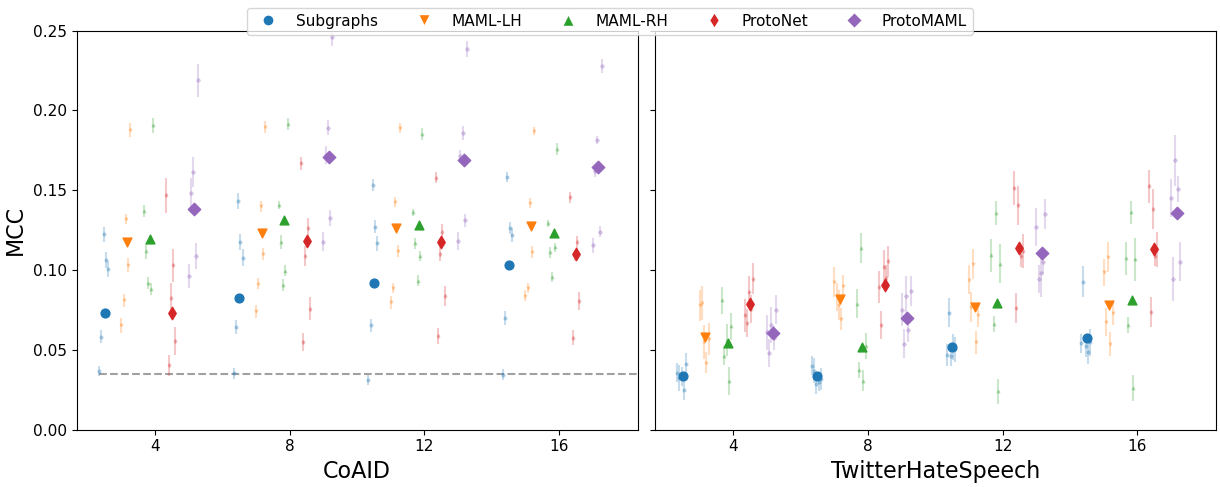

In [34]:
metric = "mcc"
lower_metric = metric.lower()

markersize_minor = 2

all_k_shots = [4, 8, 12, 16]

fig, axes = plt.subplots(1, 2, figsize=(2 * figsize[0], figsize[1]), layout="constrained")

custom_lines = []
for ax_num, (dataset_name, transfer_results, ax) in enumerate(zip(["CoAID", "TwitterHateSpeech"], [coaid_transfer, twitter_transfer], axes)):
    aggregated_df = normalize_by_group(
        df=transfer_results,
        by=["k", "learning_algorithm"],
        metric=metric,
    )

    x_ticks = []
    x_tick_labels = []

    agg_values = defaultdict(list)

    prev_k_loc = 0
    cur_x = 0

    if dataset_name in {"CoAID"}:
        zero_shot_vals = zero_shot_transfer_baseline[metric].to_numpy()

        ax.hlines(
            y=zero_shot_vals.mean(),
            xmin=0,
            xmax=1000,
            colors=["gray"],
            zorder=1,
            linestyles="--",
            alpha=0.75,
            )

    for k in all_k_shots:
        matching_k = transfer_results["k"] == k

        for i, (learning_algorithm, ckpts) in enumerate(checkpoints.items()):
            matching_learning_alg = matching_k & (
                transfer_results["learning_algorithm"] == learning_algorithm
            )

            color = checkpoint_cmap[learning_algorithm]
            fmt = checkpoint_fmt[learning_algorithm]

            for ckpt in ckpts:
                matching_ckpt = matching_learning_alg & (
                    transfer_results["checkpoint"] == ckpt
                )

                if transfer_results[matching_ckpt][lower_metric].shape[0] > 1:
                    raise KeyboardInterrupt()
                elif transfer_results[matching_ckpt][lower_metric].shape[0] == 0:
                    cur_x += 1
                    continue

                value = transfer_results[matching_ckpt][lower_metric].item()
                value_error = (
                    value
                    - transfer_results[matching_ckpt][f"{lower_metric}_lb"].item()
                )

                ax.errorbar(
                    cur_x,
                    value,
                    yerr=value_error,
                    fmt=fmt,
                    color=color,
                    alpha=0.25,
                    zorder=1,
                    markersize=markersize_minor,
                )
                cur_x += 1

            agg_row = aggregated_df.xs(key=(k, learning_algorithm))
            agg_value = agg_row[metric].item()
            agg_error = (agg_row[f"{metric}_ub"] - agg_row[metric]).item()

            agg_loc = cur_x - len(ckpts) / 2

            ax.scatter(
                agg_loc,
                agg_value,
                marker=fmt,
                color=color,
                alpha=1.0,
                label=learning_algorithm,
                zorder=2,
                s=5 * markersize_major,
            )

            agg_values[learning_algorithm] += [agg_value]

            if ax_num == 0:
                custom_lines += [
                    Line2D([0], [0], marker=fmt, markerfacecolor=color, color='w', lw=0, markersize=markersize_major),
                ]

            cur_x += 5

        x_ticks += [(prev_k_loc + cur_x) / 2]
        x_tick_labels += [k]

        cur_x += 10
        prev_k_loc = cur_x

    all_k_shots_range = np.arange(min(x_ticks), max(x_ticks), step=1, dtype=float)
    all_k_shots_x = np.stack(
        [np.ones_like(all_k_shots_range, dtype=float), all_k_shots_range], axis=1
    )

    for i, (learning_algorithm, values) in enumerate(agg_values.items()):
        color = checkpoint_cmap[learning_algorithm]

        #ax.plot(x_ticks, values, c=color, alpha=1, zorder=0, linewidth=1)

    ax.set_title(" ", fontsize=16)

    ax.set_xlim(-10, cur_x)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels, fontsize=fontsize_minor)

    ax.set_ylim(0, 0.25)
    ax.set_yticks([0.0, 0.05, 0.10, 0.15, 0.20, 0.25])
    ax.set_yticklabels(["0.00", "0.05", "0.10", "0.15", "0.20", "0.25"], fontsize=fontsize_minor)

    ax.set_xlabel(dataset_name, fontsize=fontsize_major)
    if ax_num == 0:
        ax.set_ylabel("MCC", fontsize=fontsize_major)
    else:
        ax.set_yticklabels([])

fig.legend(
    custom_lines,
    ["Subgraphs", "MAML-LH", "MAML-RH", "ProtoNet", "ProtoMAML"],
    loc='upper center',
    #bbox_to_anchor=(0.5, 1.25),
    fontsize=fontsize_minor,
    ncol=5,
    )


## Extreme $k$-shot

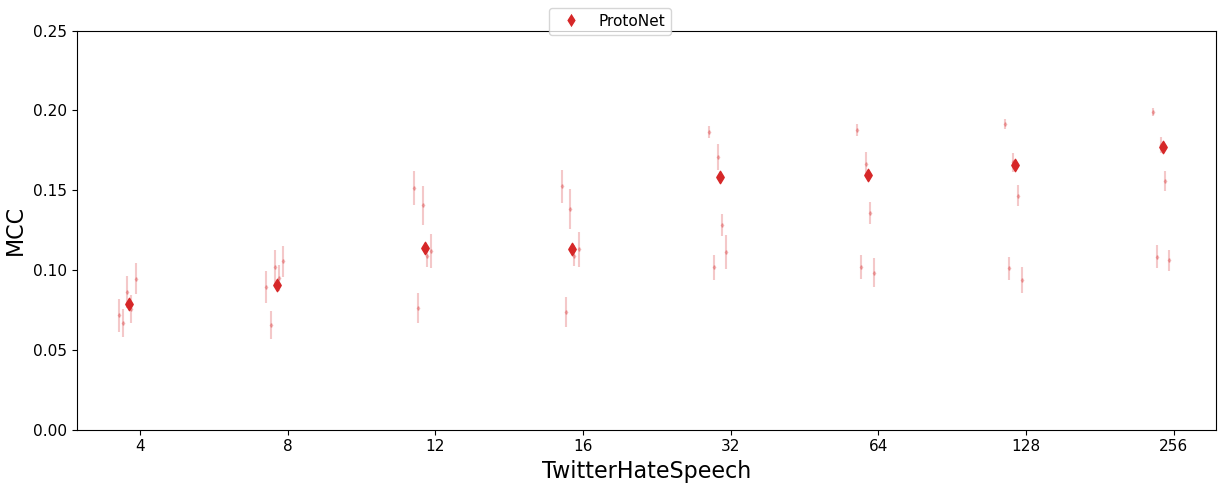

In [35]:
metric = "mcc"

lower_metric = metric.lower()

fig, ax = plt.subplots(1, 1, figsize=(2 * figsize[0], figsize[1]), layout="constrained")

tested_learning_algorithms = [
    "prototypical"
]

all_k_shots = [4, 8, 12, 16, 32, 64, 128, 256]

custom_lines = []

for checkpoint_type, checkpoint_results in [("gat", twitter_transfer)]:

    aggregated_df = normalize_by_group(
        df=checkpoint_results,
        by=["k", "learning_algorithm"],
        metric=metric,
    )

    aggregated_df = aggregated_df.loc[pd.IndexSlice[:, tested_learning_algorithms], :]

    prev_k_loc = 0
    cur_x = 0

    x_ticks = []
    x_tick_labels = []

    agg_values = defaultdict(list)

    for k in all_k_shots:
        matching_k = checkpoint_results["k"] == k

        for i, (learning_algorithm, ckpts) in enumerate(checkpoints.items()):
            if learning_algorithm not in {"prototypical"}:
                continue

            matching_learning_alg = matching_k & (
                twitter_transfer["learning_algorithm"] == learning_algorithm
            )

            color = checkpoint_cmap[learning_algorithm]
            fmt = checkpoint_fmt[learning_algorithm]

            for ckpt in ckpts:
                matching_ckpt = matching_learning_alg & (
                    twitter_transfer["checkpoint"] == ckpt
                )

                if twitter_transfer[matching_ckpt][lower_metric].shape[0] > 1:
                    raise KeyboardInterrupt()
                elif twitter_transfer[matching_ckpt][lower_metric].shape[0] == 0:
                    cur_x += 1
                    continue

                value = twitter_transfer[matching_ckpt][lower_metric].item()
                value_error = (
                    value
                    - twitter_transfer[matching_ckpt][f"{lower_metric}_lb"].item()
                )

                ax.errorbar(
                    cur_x,
                    value,
                    yerr=value_error,
                    fmt=fmt,
                    color=color,
                    alpha=0.25,
                    zorder=1,
                    markersize=markersize_minor,
                )
                cur_x += 1

            agg_row = aggregated_df.xs(key=(k, learning_algorithm))
            agg_value = agg_row[metric].item()
            agg_error = (agg_row[f"{metric}_ub"] - agg_row[metric]).item()

            agg_loc = cur_x - len(ckpts) / 2

            ax.scatter(
                agg_loc,
                agg_value,
                marker=fmt,
                color=color,
                alpha=1.0,
                label=learning_algorithm,
                zorder=2,
                s=5 * markersize_major,
            )

            agg_values[learning_algorithm] += [agg_value]

            cur_x += 5

        x_ticks += [(prev_k_loc + cur_x) / 2]
        x_tick_labels += [k]

        cur_x += 25
        prev_k_loc = cur_x

ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)

learning_algorithm = "prototypical"
    
color = checkpoint_cmap[learning_algorithm]

custom_lines += [
    Line2D([0], [0], marker='D', markerfacecolor=color, color='w', lw=0, markersize=markersize_major),
]

ax.set_title(" ", fontsize=16)

ax.set_xlim(-10, cur_x-20)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels, fontsize=fontsize_minor)

ax.set_ylim(0, 0.25)
ax.set_yticks([0.0, 0.05, 0.10, 0.15, 0.20, 0.25])
ax.set_yticklabels(["0.00", "0.05", "0.10", "0.15", "0.20", "0.25"], fontsize=fontsize_minor)

ax.set_xlabel(dataset_name, fontsize=fontsize_major)
ax.set_ylabel("MCC", fontsize=fontsize_major)

fig.legend(
    [
        Line2D([0], [0], marker=fmt, markerfacecolor=color, color='w', lw=0, markersize=markersize_major)
        ],
    ["ProtoNet"],
    loc='upper center',
    #bbox_to_anchor=(0.5, 1.25),
    fontsize=fontsize_minor,
    ncol=5,
    )

plt.show()